In [1]:
import numpy as nu
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import leidenalg

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor='white')

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


In [3]:
adata = sc.read("/home/jovyan/ifbdata/spatial_cell_id/Kush/data/Clarins_concatenated_adata.h5ad")

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.write("/home/jovyan/ifbdata/spatial_cell_id/Kush/Scanpy_analysis/cache.h5ad")

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata

AnnData object with n_obs × n_vars = 783686 × 20116
    obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication'

In [6]:
adata.var_names_make_unique() #makes the gene names unique by appending a number string to each duplicate index element

In [41]:
adata.var['ribo'] = adata.var_names.str.startswith(("RpS","RpL"))
adata.var['mt'] = adata.var_names.str.startswith(("Mt", "MT")) #had to include "MT"

sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

/tmp/ipykernel_1460826/2441231406.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ribo'] = adata.var_names.str.startswith(("RpS","RpL"))
/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


normalizing counts per cell
    finished (0:00:05)


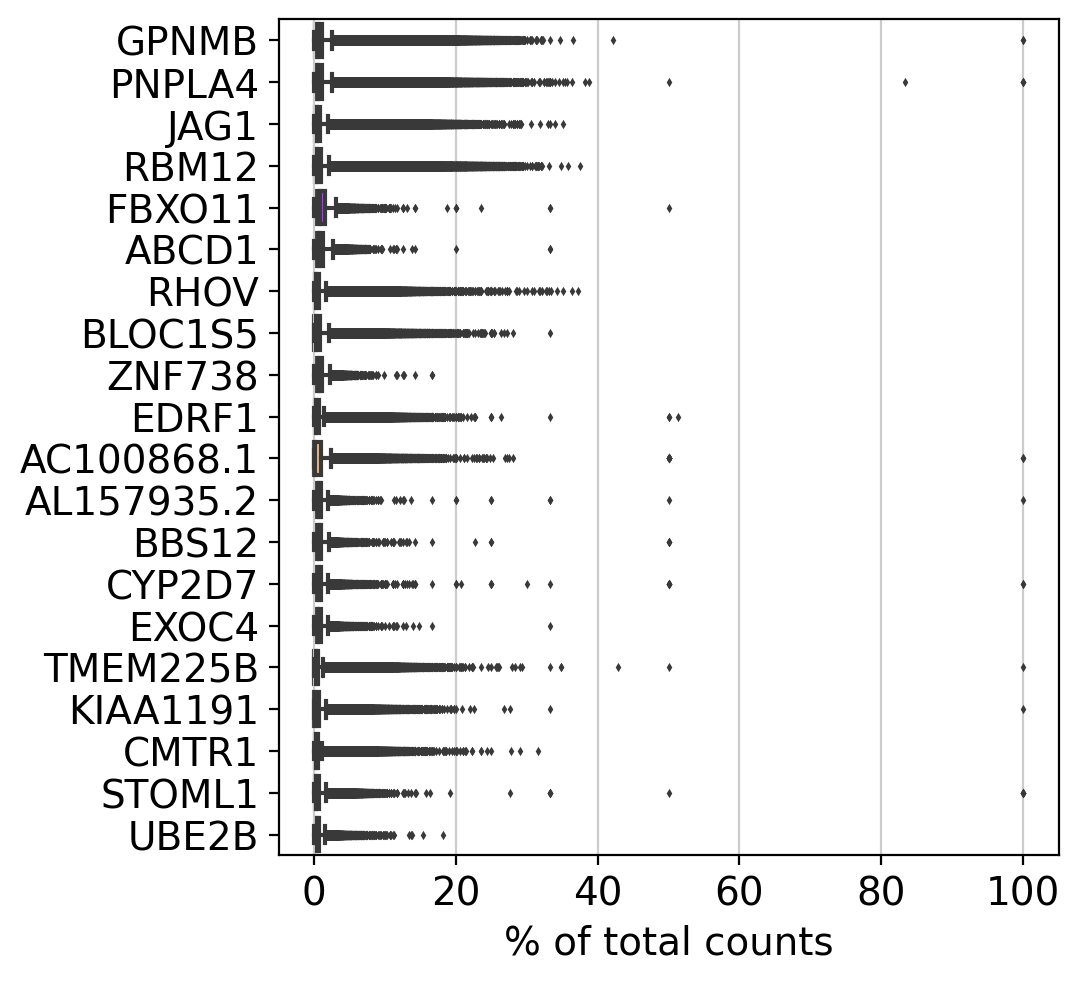

In [42]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

In [43]:
print(adata.obs['Publication'].value_counts())

Publication
multiscale_spacial_mapping               277497
eyelids_full_skin                        232958
multiscale_spacial_mapping_2             187488
sun_protected_human_skin_inguinoiliac     31288
atopic_dermatitis_healthy                 27090
Dermal_sheath_outer_forearm               24577
photoaging_extensor_side                   1936
Name: count, dtype: int64


In [44]:
print(adata.obs.index.is_unique)  #False = which means the index (which are cells) have duplicates 

True


In [19]:
print(adata.obs.index[adata.obs.index.duplicated()]) #524412 duplicate cells (66.9%) 

Index(['AAGCAGTGGTATCAAC', 'GATCATGTCGGCTTCT', 'CTCATGCAGCCGCACT',
       'GAGTTACCAAACACCT', 'TCCCACACAAGCCCAC', 'TAAGTCGCAAAGAGTT',
       'GCAGTGGTATCAACGC', 'TGTCCCACACAATGAA', 'ATGGGAGTCCTTATAC',
       'GCATCCTCTCCTATTA',
       ...
       'CGCCAAGTCCAAGCCG', 'ACGCCAGAGCTAGGCA', 'CGTAGGCAGCTAAGAT',
       'CACTCCACAAGACGTG', 'CGACTTCGTCGAATCT', 'TTGACTTGTTTAAGCC',
       'GCGCCAAGTACGAAAT', 'CAGCCGAGTTCCCTTG', 'TGTCCCAGTTATTCTC',
       'GTAACGTTCTTTACAC'],
      dtype='object', length=524412)


In [20]:
adata.obs['cell_names'] = adata.obs.index #making the cells column to a new column instead of index
adata.obs.reset_index(drop=True, inplace=True) #and re indexing to unique numbering from 0  
# to not loose the info about cells and still be able to use index for grouping

In [45]:
adata.obs

,Dataset,Age,Sex,Skin area,Ethnicity,Publication,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,cell_names
0,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2492,8085.142578,0.0,0.0,60.833336,0.752409,GAACACTTCATTGCGA
1,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3143,10122.234375,0.0,0.0,46.333332,0.457738,TCTCACGTCCGCACTT
2,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2818,7325.214844,0.0,0.0,38.833336,0.530132,CTCCAACTCTCCTACG
3,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2762,8198.296875,0.0,0.0,29.000000,0.353732,AGATGAAAGACTCGAG
4,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3401,13108.109375,0.0,0.0,68.000000,0.518763,GCTACCTAGCAATAAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783681,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,283,420.452362,0.0,0.0,1.000000,0.237839,ACTCTAATCGGTTAAC
783682,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,44,51.250000,0.0,0.0,0.000000,0.000000,AGACGTTTCCGTACAA
783683,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,50,53.833332,0.0,0.0,0.000000,0.000000,CCGGGATCAGCAGTTT
783684,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,49,58.000000,0.0,0.0,0.000000,0.000000,CGGTTAACAAGTCTAC


In [46]:
print(adata.obs.index.is_unique) #now that the indexes are true

True


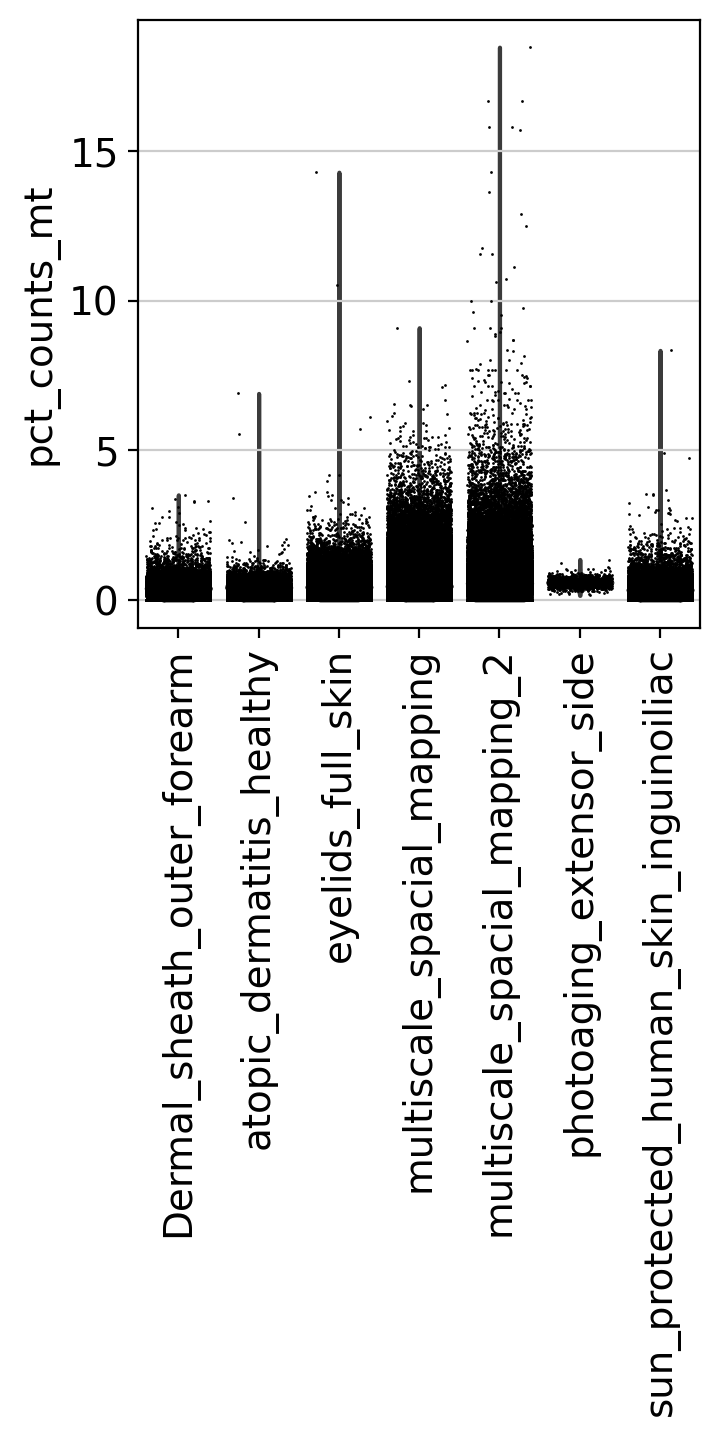

In [47]:
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, groupby = 'Publication', rotation= 90)
# percentage of mitochondrial gene expression 

In [50]:
# filter the cells expressing more than 20% of mitochondrial genes (852 removed)
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

print("Remaining cells %d" %adata.n_obs)

Remaining cells 782834


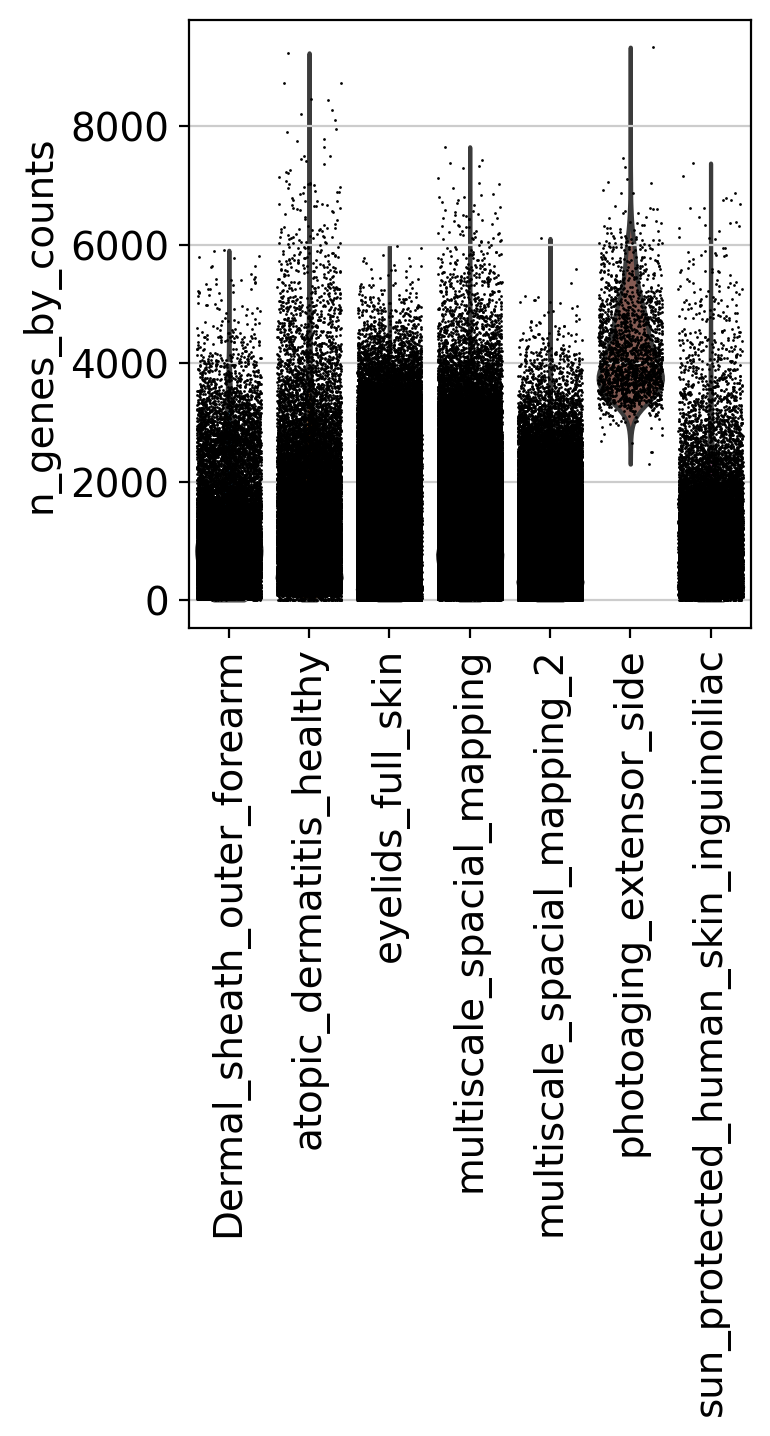

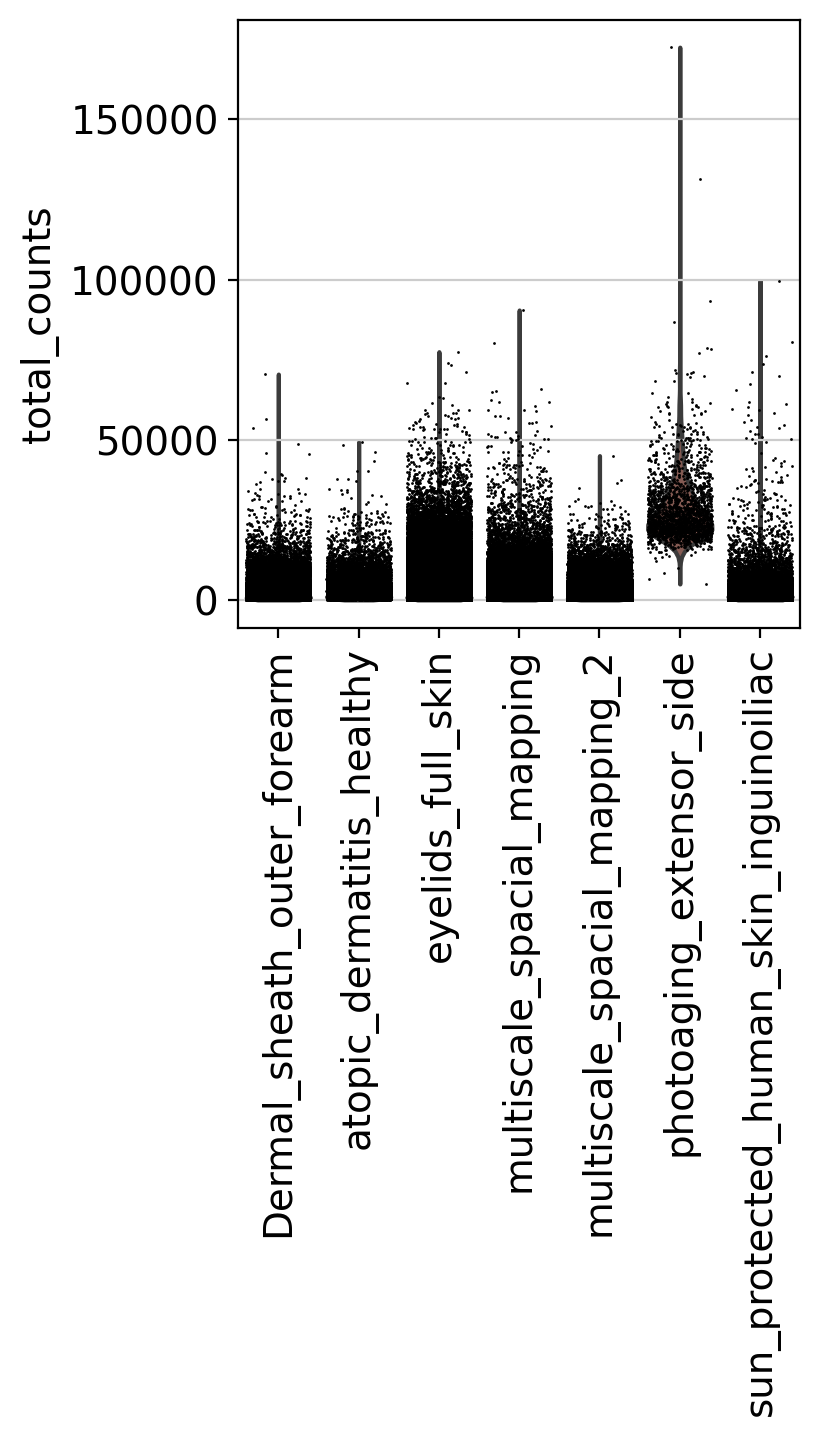

In [68]:
# visualizing the number of genes and the total counts for each publication
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, groupby = 'Publication', rotation= 90, subfigsize=(5, 3))
sc.pl.violin(adata, ['total_counts'], jitter=0.4, groupby = 'Publication', rotation= 90)

# n_genes_by_counts = how many genes are being actively transcribed in the cell (number of genes that have non-zero expression)
# total_counts = total number of RNA counts (or reads) for a particular cell (sum of all gene expression counts for that cell)